# Extrinsic NLP Task for Sentiment Analysis using a Word Embedding

In [1]:
import re
from pathlib import Path

PROJECT_ROOT = Path().absolute().parent

In [2]:
import embedeval
from embedeval.parsers.word2vec_gensim import load_embedding

In [3]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling1D
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [4]:
from embedeval.tasks.offense_detection import f1_metric

## Loading the Word Embedding

In [5]:
EMBEDDING_PATH = PROJECT_ROOT / "tests" / "data" / "downloads" / "cc.de.300.vec"

In [6]:
embedding = load_embedding(EMBEDDING_PATH)

## Prepare Text Corpus

In [7]:
train_dataset_file = PROJECT_ROOT / "src" / "embedeval" / "tasks" / "data" / "germeval-2018" / "train.txt"
test_dataset_file = PROJECT_ROOT / "src" / "embedeval" / "tasks" / "data" / "germeval-2018" / "test.txt"

In [8]:
def load_dataset(corpus_file):
    df = pd.read_csv(corpus_file, sep="\t", names=["tweet", "label"], usecols=[0, 1])
    df["label"] = df["label"].map({"OFFENSE": 1, "OTHER": 0})
    
    # remove words starting with an @ from all tweets
    def remove_mentions(text):
        return re.sub(r"@[A-Za-z0-9_]{3,}", "", text)
        
    df["tweet"] = df["tweet"].apply(remove_mentions)
    
    return df

### Load Train and Test Datasets

In [9]:
train_df = load_dataset(train_dataset_file)
test_df = load_dataset(test_dataset_file)

In [10]:
train_df.head()

,tweet,label
0,"Liebe Corinna, wir würden dich gerne als Mode...",0
1,Sie haben ja auch Recht. Unser Tweet war etwa...,0
2,fröhlicher gruß aus der schönsten stadt der w...,0
3,Amis hätten alles und jeden gewählt...nur Hil...,0
4,kein verläßlicher Verhandlungspartner. Nachka...,1


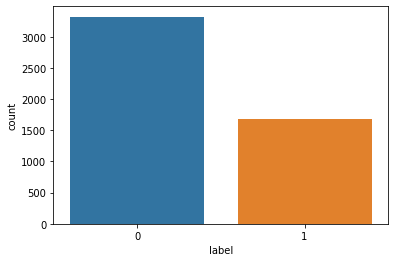

In [11]:
sns.countplot(train_df["label"])

In [12]:
test_df.head()

,tweet,label
0,"Meine Mutter hat mir erzählt, dass mein Vater ...",0
1,Meine Reaktion; |LBR| Nicht jeder Moslem ist...,0
2,"#Merkel rollt dem Emir von #Katar, der islamis...",0
3,„Merle ist kein junges unschuldiges Mädchen“ K...,0
4,Asylantenflut bringt eben nur negatives für D...,1


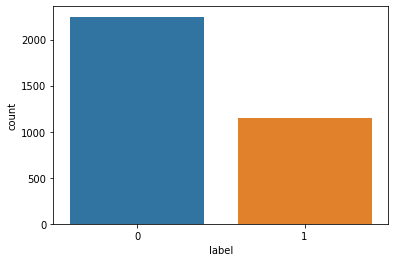

In [13]:
sns.countplot(test_df["label"])

### Tokenize Text Corpus

In [14]:
def calculate_sentence_length(corpus):
    word_count = lambda sentence: len(word_tokenize(sentence))
    longest_sentence = max(corpus, key=word_count)
    length_long_sentence = len(word_tokenize(longest_sentence))
    
    return length_long_sentence
    

def tokenize_corpus(corpus):
    word_tokenizer = Tokenizer()
    word_tokenizer.fit_on_texts(corpus)
    
    return word_tokenizer


def pad_text(corpus, text, sentence_length):
    padded_text = pad_sequences(text, sentence_length, padding='post')
    return padded_text


def prepare_corpus(corpus, tokenizer, sentence_length):
    text = tokenizer.texts_to_sequences(corpus)
    padded_text = pad_text(corpus, text, sentence_length)
    
    return padded_text

In [15]:
entire_corpus = pd.concat([train_df, test_df])["tweet"]
tokenizer = tokenize_corpus(entire_corpus)

sentence_length = calculate_sentence_length(entire_corpus)

train_corpus = prepare_corpus(train_df["tweet"], tokenizer, sentence_length)
test_corpus = prepare_corpus(test_df["tweet"], tokenizer, sentence_length)

### Create Embedding Matrix for Corpus

In [16]:
def create_embedding_matrix(embedding, tokenizer):
    # Get the Vocabulary length and add 1 for all unknown words
    vocab_length = len(tokenizer.word_index) + 1
    
    embedding_matrix = np.zeros((vocab_length, 300))
    
    for word, index in tokenizer.word_index.items():
        try:
            embedding_vector = embedding.get_word_vector(word)
        except KeyError:
            embedding_vector = None
            
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

In [17]:
train_embedding_matrix = create_embedding_matrix(embedding, tokenizer)

## Create Keras Model for Sentimental Analysis

In [18]:
model = Sequential()
model.add(Embedding(
    train_embedding_matrix.shape[0], 
    train_embedding_matrix.shape[1], 
    weights=[train_embedding_matrix], 
    input_length=sentence_length, 
    #trainable=False,
    trainable=True
))

#model.add(GlobalAveragePooling1D())
#model.add(Dense(16, activation='relu'))

model.add(Flatten())

# model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))     SLOW AF

#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_metric])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 695, 300)          6482700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 208500)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 208501    
Total params: 6,691,201
Trainable params: 6,691,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_corpus, train_df["label"], validation_split=0.3, epochs=5, verbose=1)

/home/tuxtimo/work/hslu-wipro/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3506 samples, validate on 1503 samples
Epoch 1/5
3506/3506 [==============================] - 13s 4ms/step - loss: 0.6376 - acc: 0.6614 - f1_metric: 0.0336 - val_loss: 0.6080 - val_acc: 0.6693 - val_f1_metric: 0.0404
Epoch 2/5
3506/3506 [==============================] - 13s 4ms/step - loss: 0.4482 - acc: 0.8175 - f1_metric: 0.6126 - val_loss: 0.5538 - val_acc: 0.7252 - val_f1_metric: 0.4971
Epoch 3/5
3506/3506 [==============================] - 13s 4ms/step - loss: 0.1899 - acc: 0.9678 - f1_metric: 0.9487 - val_loss: 0.5360 - val_acc: 0.7272 - val_f1_metric: 0.4899
Epoch 4/5
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0688 - acc: 0.9969 - f1_metric: 0.9950 - val_loss: 0.5481 - val_acc: 0.7279 - val_f1_metric: 0.4987
Epoch 5/5
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0314 - acc: 0.9991 - f1_metric: 0.9988 - val_loss: 0.5644 - val_acc: 0.7299 - val_f1_metric: 0.5053


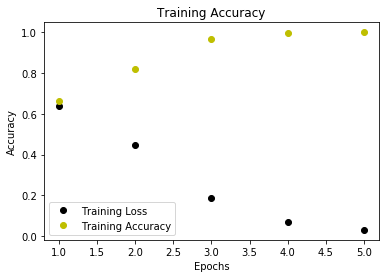

In [21]:
loss = history.history['loss']
acc = history.history['acc']

epochs = list(range(1, 6))

plt.plot(epochs, loss, 'ko', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.plot(epochs, acc, 'yo', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

## Evaluate Model

In [22]:
loss, accuracy, f1_score = model.evaluate(test_corpus, test_df["label"], verbose=0)

loss, accuracy, f1_score

(0.6386607337026051, 0.7054149508476257, 0.4186004102230072)